In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle

from model import PolynomialActivation
from train import fit_activation
from utils import get_max_firing_rate
from data import get_raw_data, preprocess_data, get_data

In [2]:
def get_activation_plot(actv, start=-100, end=270):
    currents = torch.linspace(start, end, steps=300)
    fs = []
    with torch.no_grad():
        for i in currents:
            f = actv(i)
            fs.append(f)
    return currents, fs

def plot_activation(Is, fs, actv, loss):
    fig, axs = plt.subplots(2)
    fig.suptitle(f"id={cell_id}, bin={bin_size}, deg={actv.degree}, loss={loss}, C={actv.C}")
    axs[0].scatter(Is, fs)
    axs[1].scatter(Is, fs)
    xs1, ys1 = get_activation_plot(actv, end=int(actv.max_current)+10)
    xs2, ys2 = get_activation_plot(actv, end=1000)
    axs[0].plot(xs1, ys1)
    axs[1].plot(xs2, ys2)
    
def get_activations(
    Is,
    fs,
    bin_size, 
    epochs=10000, 
    repeats=1,
    C=0,
    degree=1,
    max_firing_rate=100,
    device=None
):  
    max_current = np.max(np.abs(Is.cpu().numpy()))
    actvs = []
    losses = []

    best_actv = None
    best_loss = 1e10

    for i in range(repeats):
        for d in range(1, degree+1):
            actv = PolynomialActivation()
            actv.init_params(d, max_current, max_firing_rate, Is, fs, C=C)
            actv.bin_size = bin_size
            actv = actv.to(device)
            criterion = torch.nn.PoissonNLLLoss(log_input=False)
            #criterion = torch.nn.HuberLoss()
            optimizer = torch.optim.Adam(actv.parameters(), lr=0.3)

            ls = fit_activation(
                actv,
                criterion,
                optimizer,
                Is,
                fs,
                epochs=epochs,
                C=C
            )

            loss = ls[-1]

            if loss < best_loss:
                best_actv, best_loss = actv, loss
            
            #plt.figure()
            #plt.plot(list(range(len(ls))), ls)
            #plt.title(f"cell_id={cell_id}, bin_size={bin_size}, degree={d}")

    actvs.append(best_actv)
    losses.append(best_loss)
    best_loss = np.min(losses)
    best_actv = actvs[np.argmin(losses)]
    return best_actv, best_loss

In [9]:
bin_size = 20
C = 0

d = {}

with open("model/max_firing_rates.pickle", "rb") as f:
    mfrs = pickle.load(f)

for cell_id in [476129135]:
    print(cell_id)
    aligned_data = get_data(cell_id, aligned=True)
    Is, fs = preprocess_data(aligned_data, bin_size=bin_size)
    Is, fs = torch.tensor(Is), torch.tensor(fs)
    max_firing_rate = mfrs[cell_id]

    # get best activation
    g, l = get_activations(
        Is,
        fs,
        bin_size, 
        epochs=500, 
        repeats=1,
        C=0,
        degree=1,
        max_firing_rate=max_firing_rate
    )
    
    d[cell_id] = (g, l)

476129135


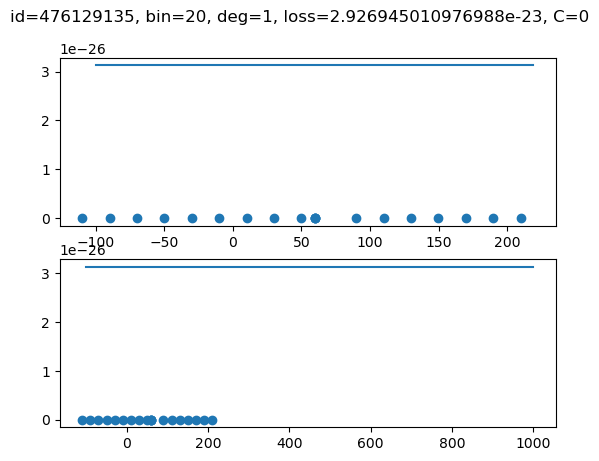

In [10]:
for cell_id in d:
    aligned_data = get_data(cell_id, aligned=True)
    Is, fs = preprocess_data(aligned_data, bin_size=bin_size)
    Is, fs = torch.tensor(Is), torch.tensor(fs)
    plot_activation(Is, fs, d[cell_id][0], d[cell_id][1])
    d[cell_id][0].save_params(f"model/activation/poisson/bin_size_{bin_size}/{cell_id}_{C}.pickle")
    plt.savefig(f"figures/activation/poisson/bin_size_{bin_size}/{cell_id}_{C}_best.png")